# TP 4: Training transformer models for text classification

# Mia Hallage

### A First Look at Hugging Face Datasets

In [13]:
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
)
import numpy as np
import evaluate


We will use Datasets to download the data from the Hugging Face Hub. We can use the list_datasets() function to see what datasets are available on the Hub:

In [ ]:
from datasets import list_datasets

all_datasets = list_datasets()
print(f"There are {len(all_datasets)} datasets currently available on the Hub")
print(f"The first 10 are: {all_datasets[:10]}")

We see that each dataset is given a name, so let's load the emotion dataset with the load_dataset() function:

In [14]:
# hide_output
from datasets import load_dataset

emotions = load_dataset("emotion")

If we look inside our emotions object:

In [15]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

we see it is similar to a Python dictionary, with each key corresponding to a different split. And we can use the usual dictionary syntax to access an individual split:

In [16]:
train_ds = emotions["train"]
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

which returns an instance of the Dataset class. The Dataset object is one of the core data structures in Datasets, and we'll be exploring many of its features throughout the course of this book. For starters, it behaves like an ordinary Python array or list, so we can query its length:

In [17]:
len(train_ds)

16000

or access a single example by its index:

In [18]:
train_ds[0]

{'text': 'i didnt feel humiliated', 'label': 0}

Here we see that a single row is represented as a dictionary, where the keys correspond to the column names:

In [19]:
train_ds.column_names

['text', 'label']

and the values are the tweet and the emotion. This reflects the fact that Datasets is based on Apache Arrow, which defines a typed columnar format that is more memory efficient than native Python. We can see what data types are being used under the hood by accessing the features attribute of a Dataset object:

In [20]:
print(train_ds.features)

{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}


In this case, the data type of the text column is string, while the label column is a special ClassLabel object that contains information about the class names and their mapping to integers. We can also access several rows with a slice:

In [21]:
print(train_ds[:5])

{'text': ['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy'], 'label': [0, 0, 3, 2, 3]}


Note that in this case, the dictionary values are now lists instead of individual elements. We can also get the full column by name:

In [22]:
print(train_ds["text"][:5])

['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy']


## 🎯 Exercise 1: Dataset Exploration

Now that you've seen how to load and explore the emotion dataset, try the following:

**Question 1** Browse the Hugging Face Datasets Hub and find another text classification dataset (e.g., imdb, ag_news, or yelp_review_full). Load this dataset and explore its structure. How many classes does it have? How is it different from the emotion dataset?


In [12]:
from datasets import load_dataset

# Load another text classification dataset
imdb = load_dataset("imdb")

imdb

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [13]:
print(imdb["train"][0])
print("Number of classes:", len(set(imdb["train"]["label"])))

{'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far be

It has to class (0=negative and 1=positive)

It is different from the emotion dataset as it is binary and has long movie reviews whereas the emotion dataset has 6 labels and short tweets

**Question 2:** The current dataset is imbalanced. Using the Pandas documentation, research and implement at least one strategy to handle class imbalance (e.g., using resample() or sample() with weights). What effect do you expect this to have on model performance?

💡 Hint: Check the Hugging Face Datasets documentation for loading different datasets and the imbalanced-learn documentation for sampling strategies.

In [14]:
import pandas as pd

df = pd.DataFrame(imdb["train"])
df.head()

,text,label
0,I rented I AM CURIOUS-YELLOW from my video sto...,0
1,"""I Am Curious: Yellow"" is a risible and preten...",0
2,If only to avoid making this type of film in t...,0
3,This film was probably inspired by Godard's Ma...,0
4,"Oh, brother...after hearing about this ridicul...",0


In [15]:
df["label"].value_counts()

label
0    12500
1    12500
Name: count, dtype: int64

Resampling strategy: undersanmpling majority class:

In [16]:
majority = df[df["label"] == 0]
minority = df[df["label"] == 1]

majority_downsampled = majority.sample(len(minority), replace=False, random_state=42)

df_balanced = pd.concat([majority_downsampled, minority])
df_balanced["label"].value_counts()

label
0    12500
1    12500
Name: count, dtype: int64

### Sidebar: What If My Dataset Is Not on the Hub?

We'll be using the Hugging Face Hub to download datasets for most of the examples in this book. But in many cases, you'll find yourself working with data that is either stored on your laptop or on a remote server in your organization. Datasets provides several loading scripts to handle local and remote datasets. Examples for the most common data formats are shown in <>.

asciidoc \
[[dataset-loading]] \
.How to load datasets in various formats \
[options="header"] \
|====== \
| Data format | Loading script | Example \
| CSV | `csv` | `load_dataset("csv", data_files="my_file.csv")` \
| Text | `text` | `load_dataset("text", data_files="my_file.txt")` \
| JSON | `json` | `load_dataset("json", data_files="my_file.jsonl")` \
|======

As you can see for each data format, we just need to pass the relevant loading script to the load_dataset() function, along with a data_files argument that specifies the path or URL to one or more files. For example, the source files for the emotion dataset are actually hosted on Dropbox, so an alternative way to load the dataset is to first download one of the splits:

In [17]:
#hide_output
# The original URL used in the book is no longer available, so we use a different one
import requests

dataset_url = "https://huggingface.co/datasets/transformersbook/emotion-train-split/raw/main/train.txt"

response = requests.get(dataset_url)
with open("train.txt", "wb") as f:
    f.write(response.content)

print("Downloaded train.txt")

Downloaded train.txt


If you’re wondering why there’s a ! character in the preceding shell command, that’s because we’re running the commands in a Jupyter notebook. Simply remove the prefix if you want to download and unzip the dataset within a terminal. Now, if we peek at the first row of the train.txt file:

In [18]:
!head -n 1 train.txt

i didnt feel humiliated;sadness


we can see that here are no column headers and each tweet and emotion are separated by a semicolon. Nevertheless, this is quite similar to a CSV file, so we can load the dataset locally by using the csv script and pointing the data_files argument to the train.txt file:

In [19]:
#hide_output
emotions_local = load_dataset("csv", data_files="train.txt", sep=";", 
                              names=["text", "label"])

Generating train split: 0 examples [00:00, ? examples/s]

Here we've also specified the type of delimiter and the names of the columns. An even simpler approach is to just point the data_files argument to the URL itself:

In [20]:
#hide_output
dataset_url = "https://huggingface.co/datasets/transformersbook/emotion-train-split/raw/main/train.txt"
emotions_remote = load_dataset("csv", data_files=dataset_url, sep=";", 
                               names=["text", "label"])

which will automatically download and cache the dataset for you. As you can see, the load_dataset() function is very versatile. We recommend checking out the Datasets documentation to get a complete overview.

### End sidebar

### From Datasets to DataFrames

Although Datasets provides a lot of low-level functionality to slice and dice our data, it is often convenient to convert a Dataset object to a Pandas DataFrame so we can access high-level APIs for data visualization. To enable the conversion, Datasets provides a set_format() method that allows us to change the output format of the Dataset. Note that this does not change the underlying data format (which is an Arrow table), and you can switch to another format later if needed:

In [28]:
import pandas as pd

emotions.set_format(type="pandas")
df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


As you can see, the column headers have been preserved and the first few rows match our previous views of the data. However, the labels are represented as integers, so let's use the int2str() method of the label feature to create a new column in our DataFrame with the corresponding label names:

In [22]:
def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


Before diving into building a classifier, let's take a closer look at the dataset. As Andrej Karpathy notes in his famous blog post "A Recipe for Training Neural Networks", becoming "one with the data" is an essential step for training great models!

### Looking at the Class Distribution

Whenever you are working on text classification problems, it is a good idea to examine the distribution of examples across the classes. A dataset with a skewed class distribution might require a different treatment in terms of the training loss and evaluation metrics than a balanced one.

With Pandas and Matplotlib, we can quickly visualize the class distribution as follows:

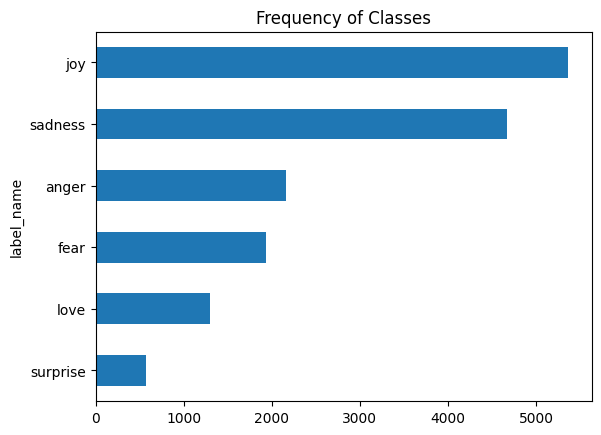

In [23]:
import matplotlib.pyplot as plt

df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

In this case, we can see that the dataset is heavily imbalanced; the joy and sadness classes appear frequently, whereas love and surprise are about 5–10 times rarer. There are several ways to deal with imbalanced data, including:

Randomly oversample the minority class.
Randomly undersample the majority class.
Gather more labeled data from the underrepresented classes.
To keep things simple in this chapter, we'll work with the raw, unbalanced class frequencies. If you want to learn more about these sampling techniques, we recommend checking out the Imbalanced-learn library. Just make sure that you don't apply sampling methods before creating your train/test splits, or you'll get plenty of leakage between them!

Now that we've looked at the classes, let's take a look at the tweets themselves.

### How Long Are Our Tweets?

Transformer models have a maximum input sequence length that is referred to as the maximum context size. For applications using DistilBERT, the maximum context size is 512 tokens, which amounts to a few paragraphs of text. As we'll see in the next section, a token is an atomic piece of text; for now, we'll treat a token as a single word. We can get a rough estimate of tweet lengths per emotion by looking at the distribution of words per tweet:

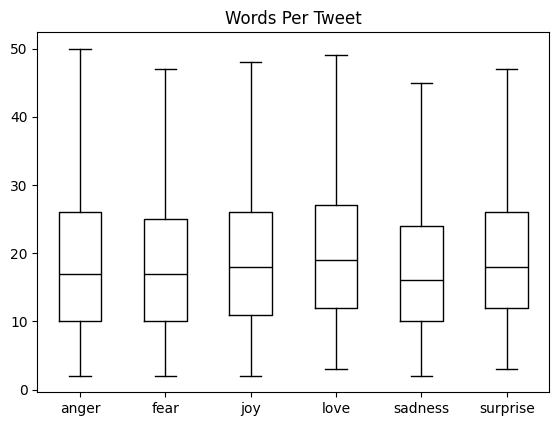

In [24]:
df["Words Per Tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words Per Tweet", by="label_name", grid=False, showfliers=False,
           color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

From the plot we see that for each emotion, most tweets are around 15 words long and the longest tweets are well below DistilBERT's maximum context size. Texts that are longer than a model's context size need to be truncated, which can lead to a loss in performance if the truncated text contains crucial information; in this case, it looks like that won't be an issue.

Let's now figure out how we can convert these raw texts into a format suitable for Transformers! While we're at it, let's also reset the output format of our dataset since we don't need the DataFrame format anymore:

In [25]:
emotions.reset_format()

### From Text to Tokens

Transformer models like DistilBERT cannot receive raw strings as input; instead, they assume the text has been tokenized and encoded as numerical vectors. Tokenization is the step of breaking down a string into the atomic units used in the model. There are several tokenization strategies one can adopt, and the optimal splitting of words into subunits is usually learned from the corpus. Before looking at the tokenizer used for DistilBERT, let's consider two extreme cases: character and word tokenization.

#### Character Tokenization

The simplest tokenization scheme is to feed each character individually to the model. In Python, str objects are really arrays under the hood, which allows us to quickly implement character-level tokenization with just one line of code:

In [24]:
text = "Mia Hallage"
tokenized_text = list(text)
print(tokenized_text)

['M', 'i', 'a', ' ', 'H', 'a', 'l', 'l', 'a', 'g', 'e']


This is a good start, but we're not done yet. Our model expects each character to be converted to an integer, a process sometimes called numericalization. One simple way to do this is by encoding each unique token (which are characters in this case) with a unique integer:

In [25]:
token2idx = {ch: idx for idx, ch in enumerate(sorted(set(tokenized_text)))}
print(token2idx)

{' ': 0, 'H': 1, 'M': 2, 'a': 3, 'e': 4, 'g': 5, 'i': 6, 'l': 7}


This gives us a mapping from each character in our vocabulary to a unique integer. We can now use token2idx to transform the tokenized text to a list of integers:

In [26]:
input_ids = [token2idx[token] for token in tokenized_text]
print(input_ids)

[2, 6, 3, 0, 1, 3, 7, 7, 3, 5, 4]


Each token has now been mapped to a unique numerical identifier (hence the name input_ids). The last step is to convert input_ids to a 2D tensor of one-hot vectors. One-hot vectors are frequently used in machine learning to encode categorical data, which can be either ordinal or nominal. For example, suppose we wanted to encode the names of characters in the Transformers TV series. One way to do this would be to map each name to a unique ID, as follows:

In [29]:
categorical_df = pd.DataFrame(
    {"Name": ["Bumblebee", "Optimus Prime", "Megatron"], "Label ID": [0,1,2]})
categorical_df

,Name,Label ID
0,Bumblebee,0
1,Optimus Prime,1
2,Megatron,2


The problem with this approach is that it creates a fictitious ordering between the names, and neural networks are really good at learning these kinds of relationships. So instead, we can create a new column for each category and assign a 1 where the category is true, and a 0 otherwise. In Pandas, this can be implemented with the get_dummies() function as follows:

In [30]:
pd.get_dummies(categorical_df["Name"])

,Bumblebee,Megatron,Optimus Prime
0,True,False,False
1,False,False,True
2,False,True,False


The rows of this DataFrame are the one-hot vectors, which have a single "hot" entry with a 1 and 0s everywhere else. Now, looking at our input_ids, we have a similar problem: the elements create an ordinal scale. This means that adding or subtracting two IDs is a meaningless operation, since the result is a new ID that represents another random token.

On the other hand, the result of adding two one-hot encodings can easily be interpreted: the two entries that are "hot" indicate that the corresponding tokens co-occur. We can create the one-hot encodings in PyTorch by converting input_ids to a tensor and applying the one_hot() function as follows:

In [31]:
import torch
import torch.nn.functional as F

input_ids = torch.tensor(input_ids)
one_hot_encodings = F.one_hot(input_ids, num_classes=len(token2idx))
one_hot_encodings.shape

torch.Size([11, 8])

For each of the 38 input tokens we now have a one-hot vector with 20 dimensions, since our vocabulary consists of 20 unique characters.

Warning: It's important to always set num_classes in the one_hot() function because otherwise the one-hot vectors may end up being shorter than the length of the vocabulary (and need to be padded with zeros manually). In TensorFlow, the equivalent function is tf.one_hot(), where the depth argument plays the role of num_classes.

By examining the first vector, we can verify that a 1 appears in the location indicated by input_ids[0]:

In [32]:
print(f"Token: {tokenized_text[0]}")
print(f"Tensor index: {input_ids[0]}")
print(f"One-hot: {one_hot_encodings[0]}")

Token: M
Tensor index: 2
One-hot: tensor([0, 0, 1, 0, 0, 0, 0, 0])


From our simple example we can see that character-level tokenization ignores any structure in the text and treats the whole string as a stream of characters. Although this helps deal with misspellings and rare words, the main drawback is that linguistic structures such as words need to be learned from the data. This requires significant compute, memory, and data. For this reason, character tokenization is rarely used in practice. Instead, some structure of the text is preserved during the tokenization step. Word tokenization is a straightforward approach to achieve this, so let's take a look at how it works.

#### Word Tokenization

Instead of splitting the text into characters, we can split it into words and map each word to an integer. Using words from the outset enables the model to skip the step of learning words from characters, and thereby reduces the complexity of the training process.

One simple class of word tokenizers uses whitespace to tokenize the text. We can do this by applying Python's split() function directly on the raw text (just like we did to measure the tweet lengths):

In [32]:
tokenized_text = text.split()
print(tokenized_text)

['Mia', 'Hallage']


From here we can take the same steps we took for the character tokenizer to map each word to an ID. However, we can already see one potential problem with this tokenization scheme: punctuation is not accounted for, so NLP. is treated as a single token. Given that words can include declinations, conjugations, or misspellings, the size of the vocabulary can easily grow into the millions!

note: Some word tokenizers have extra rules for punctuation. One can also apply stemming or lemmatization, which normalizes words to their stem (e.g., "great", "greater", and "greatest" all become "great"), at the expense of losing some information in the text.

Having a large vocabulary is a problem because it requires neural networks to have an enormous number of parameters. To illustrate this, suppose we have 1 million unique words and want to compress the 1-million-dimensional input vectors to 1-thousand-dimensional vectors in the first layer of our neural network. This is a standard step in most NLP architectures, and the resulting weight matrix of this first layer would contain 1 million $\times$ 1 thousand = 1 billion weights. This is already comparable to the largest GPT-2 model,footnote:[GPT-2 is the successor of GPT, and it captivated the public's attention with its impressive ability to generate realistic text. We'll explore GPT-2 in detail in <<chapter_summarization>>.] which has around 1.5 billion parameters in total!

Naturally, we want to avoid being so wasteful with our model parameters since models are expensive to train, and larger models are more difficult to maintain. A common approach is to limit the vocabulary and discard rare words by considering, say, the 100,000 most common words in the corpus. Words that are not part of the vocabulary are classified as "unknown" and mapped to a shared UNK token. This means that we lose some potentially important information in the process of word tokenization, since the model has no information about words associated with UNK.

Wouldn't it be nice if there was a compromise between character and word tokenization that preserved all the input information and some of the input structure? There is: subword tokenization.

#### Subword Tokenization

The basic idea behind subword tokenization is to combine the best aspects of character and word tokenization. On the one hand, we want to split rare words into smaller units to allow the model to deal with complex words and misspellings. On the other hand, we want to keep frequent words as unique entities so that we can keep the length of our inputs to a manageable size. The main distinguishing feature of subword tokenization (as well as word tokenization) is that it is learned from the pretraining corpus using a mix of statistical rules and algorithms.

There are several subword tokenization algorithms that are commonly used in NLP, but let's start with WordPiece,footnote:[M. Schuster and K. Nakajima, "Japanese and Korean Voice Search," 2012 IEEE International Conference on Acoustics, Speech and Signal Processing (2012): 5149–5152, https://doi.org/10.1109/ICASSP.2012.6289079.] which is used by the BERT and DistilBERT tokenizers. The easiest way to understand how WordPiece works is to see it in action. Transformers provides a convenient AutoTokenizer class that allows you to quickly load the tokenizer associated with a pretrained model—we just call its from_pretrained() method, providing the ID of a model on the Hub or a local file path. Let's start by loading the tokenizer for DistilBERT:

In [33]:
# hide_output
from transformers import AutoTokenizer

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

/opt/anaconda3/envs/nlp_tp/lib/python3.11/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


The AutoTokenizer class belongs to a larger set of "auto" classes whose job is to automatically retrieve the model's configuration, pretrained weights, or vocabulary from the name of the checkpoint. This allows you to quickly switch between models, but if you wish to load the specific class manually you can do so as well. For example, we could have loaded the DistilBERT tokenizer as follows:

In [34]:
from transformers import DistilBertTokenizer

distilbert_tokenizer = DistilBertTokenizer.from_pretrained(model_ckpt)

note: When you run the AutoTokenizer.from_pretrained() method for the first time you will see a progress bar that shows which parameters of the pretrained tokenizer are loaded from the Hugging Face Hub. When you run the code a second time, it will load the tokenizer from the cache, usually located at ~/.cache/huggingface/.

Let's examine how this tokenizer works by feeding it our simple "Tokenizing text is a core task of NLP." example text:

In [35]:
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 8764, 2534, 4270, 102], 'attention_mask': [1, 1, 1, 1, 1]}


Just like we saw with character tokenization, we can see that the words have been mapped to unique integers in the input_ids field. We'll discuss the role of the attention_mask field in the next section. Now that we have the input_ids, we can convert them back into tokens by using the tokenizer's convert_ids_to_tokens() method:

In [36]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'mia', 'hall', '##age', '[SEP]']


We can observe three things here. First, some special [CLS] and [SEP] tokens have been added to the start and end of the sequence. These tokens differ from model to model, but their main role is to indicate the start and end of a sequence. Second, the tokens have each been lowercased, which is a feature of this particular checkpoint. Finally, we can see that "tokenizing" and "NLP" have been split into two tokens, which makes sense since they are not common words. The ## prefix in ##izing and ##p means that the preceding string is not whitespace; any token with this prefix should be merged with the previous token when you convert the tokens back to a string. The AutoTokenizer class has a convert_tokens_to_string() method for doing just that, so let's apply it to our tokens

In [37]:
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] mia hallage [SEP]


The AutoTokenizer class also has several attributes that provide information about the tokenizer. For example, we can inspect the vocabulary size:

In [38]:
tokenizer.vocab_size

30522

and the corresponding model's maximum context size:

In [39]:
tokenizer.model_max_length

512

Another interesting attribute to know about is the names of the fields that the model expects in its forward pass:

In [41]:
tokenizer.model_input_names

['input_ids', 'attention_mask']

Now that we have a basic understanding of the tokenization process for a single string, let's see how we can tokenize the whole dataset!

warning: When using pretrained models, it is really important to make sure that you use the same tokenizer that the model was trained with. From the model's perspective, switching the tokenizer is like shuffling the vocabulary. If everyone around you started swapping random words like "house" for "cat," you'd have a hard time understanding what was going on too!

#### Tokenizing the Whole Dataset

To tokenize the whole corpus, we'll use the map() method of our DatasetDict object. We'll encounter this method many times throughout this book, as it provides a convenient way to apply a processing function to each element in a dataset. As we'll soon see, the map() method can also be used to create new rows and columns.

To get started, the first thing we need is a processing function to tokenize our examples with:

In [42]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

This function applies the tokenizer to a batch of examples; padding=True will pad the examples with zeros to the size of the longest one in a batch, and truncation=True will truncate the examples to the model's maximum context size. To see tokenize() in action, let's pass a batch of two examples from the training set:

In [ ]:
print(tokenize(emotions["train"][:2]))

Here we can see the result of padding: the first element of input_ids is shorter than the second, so zeros have been added to that element to make them the same length. These zeros have a corresponding [PAD] token in the vocabulary, and the set of special tokens also includes the [CLS] and [SEP] tokens that we encountered earlier:

In [44]:
#hide_input
tokens2ids = list(zip(tokenizer.all_special_tokens, tokenizer.all_special_ids))
data = sorted(tokens2ids, key=lambda x : x[-1])
df = pd.DataFrame(data, columns=["Special Token", "Special Token ID"])
df.T

,0,1,2,3,4
Special Token,[PAD],[UNK],[CLS],[SEP],[MASK]
Special Token ID,0,100,101,102,103


Also note that in addition to returning the encoded tweets as input_ids, the tokenizer returns a list of attention_mask arrays. This is because we do not want the model to get confused by the additional padding tokens: the attention mask allows the model to ignore the padded parts of the input. For each batch, the input sequences are padded to the maximum sequence length in the batch; the attention mask is used in the model to ignore the padded areas of the input tensors.

Once we've defined a processing function, we can apply it across all the splits in the corpus in a single line of code:

In [10]:
# hide_output
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

By default, the map() method operates individually on every example in the corpus, so setting batched=True will encode the tweets in batches. Because we've set batch_size=None, our tokenize() function will be applied on the full dataset as a single batch. This ensures that the input tensors and attention masks have the same shape globally, and we can see that this operation has added new input_ids and attention_mask columns to the dataset:

In [47]:
print(emotions_encoded["train"].column_names)

['text', 'label', 'input_ids', 'attention_mask']


Note: In later chapters, we'll see how data collators can be used to dynamically pad the tensors in each batch. Padding globally will come in handy in the next section, where we extract a feature matrix from the whole corpus.

### Training a Text Classifier

As discussed in <<chapter_introduction>>, models like DistilBERT are pretrained to predict masked words in a sequence of text. However, we can't use these language models directly for text classification; we need to modify them slightly. To understand what modifications are necessary, let's take a look at the architecture of an encoder-based model like DistilBERT.

First, the text is tokenized and represented as one-hot vectors called token encodings. The size of the tokenizer vocabulary determines the dimension of the token encodings, and it usually consists of 20k–200k unique tokens. Next, these token encodings are converted to token embeddings, which are vectors living in a lower-dimensional space. The token embeddings are then passed through the encoder block layers to yield a hidden state for each input token. For the pretraining objective of language modeling,⁠footnote:[In the case of DistilBERT, it's guessing the masked tokens.] each hidden state is fed to a layer that predicts the masked input tokens. For the classification task, we replace the language modeling layer with a classification layer.

note: In practice, PyTorch skips the step of creating one-hot vectors for token encodings because multiplying a matrix with a one-hot vector is the same as selecting a column from the matrix. This can be done directly by getting the column with the token ID from the matrix. We'll see this in <<chapter_anatomy>> when we use the nn.Embedding class.

We have two options to train such a model on our Twitter dataset:

- Feature extraction:: We use the hidden states as features and just train a classifier on them, without modifying the pretrained model.
- Fine-tuning:: We train the whole model end-to-end, which also updates the parameters of the pretrained model.\
In the following sections we explore both options for DistilBERT and examine their trade-offs.

#### Transformers as Feature Extractors

Using a transformer as a feature extractor is fairly simple. We freeze the body's weights during training and use the hidden states as features for the classifier. The advantage of this approach is that we can quickly train a small or shallow model. Such a model could be a neural classification layer or a method that does not rely on gradients, such as a random forest. This method is especially convenient if GPUs are unavailable, since the hidden states only need to be precomputed once.

**Using pretrained models**

We will use another convenient auto class from Transformers called AutoModel. Similar to the AutoTokenizer class, AutoModel has a from_pretrained() method to load the weights of a pretrained model. Let's use this method to load the DistilBERT checkpoint:

In [48]:
# hide_output
from transformers import AutoModel

model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

/opt/anaconda3/envs/nlp_tp/lib/python3.11/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


### 🎯 Exercise 2: Tokenization Experiments

Understanding how tokenization affects model performance is crucial. Try the following experiments:

**Question 1:** Load a different pre-trained model tokenizer (e.g., bert-base-cased, roberta-base, or albert-base-v2) and compare its tokenization output with DistilBERT. Use the Hugging Face Models Hub to find available models. What differences do you notice? How does cased vs uncased tokenization affect the output?

In [49]:
from transformers import AutoTokenizer

text = "I am very tired of revising for exams!"

tok_distilbert = AutoTokenizer.from_pretrained("distilbert-base-uncased")
tok_bert_cased = AutoTokenizer.from_pretrained("bert-base-cased")
tok_roberta = AutoTokenizer.from_pretrained("roberta-base")

# Tokenize with each model
out_distilbert = tok_distilbert.tokenize(text)
out_bert_cased = tok_bert_cased.tokenize(text)
out_roberta = tok_roberta.tokenize(text)

print("DistilBERT:", out_distilbert)
print("BERT cased:", out_bert_cased)
print("RoBERTa:", out_roberta)


DistilBERT: ['i', 'am', 'very', 'tired', 'of', 'rev', '##ising', 'for', 'exams', '!']
BERT cased: ['I', 'am', 'very', 'tired', 'of', 're', '##vis', '##ing', 'for', 'exams', '!']
RoBERTa: ['I', 'Ġam', 'Ġvery', 'Ġtired', 'Ġof', 'Ġrev', 'ising', 'Ġfor', 'Ġexams', '!']


Different tokenizers segment the same input differently because they use different rules. DistilBERT lowercases the text, BERT cased preserves capitalization. 

RoBERTa uses the “Ġ” marker for word boundaries, while BERT uses WordPiece and produces more subword splits.  

**Question 2:** Experiment with the tokenizer's padding and truncation parameters. What happens if you set max_length=10 with truncation=True? Read the tokenizer documentation to understand different padding strategies (max_length, longest, do_not_pad).

In [50]:
encoded_default = tok_distilbert(text)
encoded_padded = tok_distilbert(text, padding="max_length", max_length=10, truncation=True)
encoded_no_pad = tok_distilbert(text, padding=False, truncation=False)

print("Default length:", len(encoded_default["input_ids"]))
print("Padded to max_length=10:", encoded_padded["input_ids"])
print("No padding:", encoded_no_pad["input_ids"])


Default length: 12
Padded to max_length=10: [101, 1045, 2572, 2200, 5458, 1997, 7065, 9355, 2005, 102]
No padding: [101, 1045, 2572, 2200, 5458, 1997, 7065, 9355, 2005, 13869, 999, 102]


When applying padding="max_length" and max_length=10, the tokenizer right-pads the sequence with pad tokens until it reaches length 10. If the original tokenized sentence is longer than 10 tokens, enabling truncation=True cuts the sequence and keeps only the first 10 tokens. Without padding, sequence length varies depending on the input text.

Here we've used PyTorch to check whether a GPU is available or not, and then chained the PyTorch nn.Module.to() method to the model loader. This ensures that the model will run on the GPU if we have one. If not, the model will run on the CPU, which can be considerably slower.

The AutoModel class converts the token encodings to embeddings, and then feeds them through the encoder stack to return the hidden states. Let's take a look at how we can extract these states from our corpus.

#### Sidebar: Interoperability Between Frameworks

Although the code in this book is mostly written in PyTorch, Transformers provides tight interoperability with TensorFlow and JAX. This means that you only need to change a few lines of code to load a pretrained model in your favorite deep learning framework! For example, we can load DistilBERT in TensorFlow by using the TFAutoModel class as follows:

In [51]:
#hide_output
from transformers import AutoModel

pt_model = AutoModel.from_pretrained(model_ckpt)
pt_model


DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Li

This interoperability is especially useful when a model is only released in one framework, but you'd like to use it in another. For example, the XLM-RoBERTa model that we'll encounter in <<chapter_ner>> only has PyTorch weights, so if you try to load it in TensorFlow as we did before:

This interoperability is especially useful when a model is only released in one framework, but you'd like to use it in another. For example, the XLM-RoBERTa model that we'll encounter in <<chapter_ner>> only has PyTorch weights, so if you try to load it in TensorFlow as we did before:

In [52]:
xlmr = AutoModel.from_pretrained("xlm-roberta-base")
xlmr


XLMRobertaModel(
  (embeddings): XLMRobertaEmbeddings(
    (word_embeddings): Embedding(250002, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): XLMRobertaEncoder(
    (layer): ModuleList(
      (0-11): 12 x XLMRobertaLayer(
        (attention): XLMRobertaAttention(
          (self): XLMRobertaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): XLMRobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=Tru

As you can see, it is very simple to switch between frameworks in Transformers! In most cases, you can just add a "TF" prefix to the classes and you'll get the equivalent TensorFlow 2.0 classes. When we use the "pt" string (e.g., in the following section), which is short for PyTorch, just replace it with "tf", which is short for TensorFlow.

**Extracting the last hidden states**

To warm up, let's retrieve the last hidden states for a single string. The first thing we need to do is encode the string and convert the tokens to PyTorch tensors. This can be done by providing the return_tensors="pt" argument to the tokenizer as follows:

In [91]:
text = "this is a test"
inputs = tokenizer(text, return_tensors="pt")
print(f"Input tensor shape: {inputs['input_ids'].size()}")

Input tensor shape: torch.Size([1, 6])


As we can see, the resulting tensor has the shape [batch_size, n_tokens]. Now that we have the encodings as a tensor, the final step is to place them on the same device as the model and pass the inputs as follows:



In [92]:
inputs = {k:v.to(device) for k,v in inputs.items()}
with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]]), hidden_states=None, attentions=None)


Here we've used the torch.no_grad() context manager to disable the automatic calculation of the gradient. This is useful for inference since it reduces the memory footprint of the computations. Depending on the model configuration, the output can contain several objects, such as the hidden states, losses, or attentions, arranged in a class similar to a namedtuple in Python. In our example, the model output is an instance of BaseModelOutput, and we can simply access its attributes by name. The current model returns only one attribute, which is the last hidden state, so let's examine its shape:

In [93]:
outputs.last_hidden_state.size()

torch.Size([1, 6, 768])

Looking at the hidden state tensor, we see that it has the shape [batch_size, n_tokens, hidden_dim]. In other words, a 768-dimensional vector is returned for each of the 6 input tokens. For classification tasks, it is common practice to just use the hidden state associated with the [CLS] token as the input feature. Since this token appears at the start of each sequence, we can extract it by simply indexing into outputs.last_hidden_state as follows:

In [94]:
outputs.last_hidden_state[:,0].size()

torch.Size([1, 768])

Now that we know how to get the last hidden state for a single string, let's do the same thing for the whole dataset by creating a new hidden_state column that stores all these vectors. As we did with the tokenizer, we'll use the map() method of DatasetDict to extract all the hidden states in one go. The first thing we need to do is wrap the previous steps in a processing function:

In [109]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [110]:
emotions_encoded.reset_format()
print(emotions_encoded["train"].column_names)

['text', 'label', 'input_ids', 'attention_mask']


In [111]:
import numpy as np

def extract_hidden_states(batch):
    # 1. Convert lists -> torch tensors and move to device
    input_ids = torch.tensor(batch["input_ids"]).to(device)
    attention_mask = torch.tensor(batch["attention_mask"]).to(device)

    # 2. Forward pass (no gradients)
    with torch.no_grad():
        # DistilBERT base model: last_hidden_state attribute
        outputs = model(input_ids=input_ids,
                        attention_mask=attention_mask)
        last_hidden_state = outputs.last_hidden_state   # shape: (batch, seq_len, hidden_dim)

    # 3. CLS token (position 0) for each example
    cls_embeddings = last_hidden_state[:, 0, :].cpu().numpy()  # shape: (batch, hidden_dim)

    # 4. Return as NumPy array (NumPy 2.0 compatible)
    return {"hidden_state": cls_embeddings}



The only difference between this function and our previous logic is the final step where we place the final hidden state back on the CPU as a NumPy array. The map() method requires the processing function to return Python or NumPy objects when we're using batched inputs.

Since our model expects tensors as inputs, the next thing to do is convert the input_ids and attention_mask columns to the "torch" format, as follows:

We can then go ahead and extract the hidden states across all splits in one go:

In [112]:
test_hidden = emotions_encoded["train"].select(range(4)).map(
    extract_hidden_states,
    batched=True
)

print(test_hidden.column_names)
print(type(test_hidden["hidden_state"][0]), np.array(test_hidden["hidden_state"][0]).shape)

Map:   0%|          | 0/4 [00:00<?, ? examples/s]

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']
<class 'list'> (768,)


In [113]:
emotions_hidden = emotions_encoded.map(
    extract_hidden_states,
    batched=True
)

emotions_hidden["train"].column_names


Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

Note that we did not set batch_size=None in this case, so the default batch_size=1000 is used instead. As expected, applying the +extract_​hid⁠den_​states()+ function has added a new hidden_state column to our dataset:

Now that we have the hidden states associated with each tweet, the next step is to train a classifier on them. To do that, we'll need a feature matrix - let's take a look.

**Creating a feature matrix**

The preprocessed dataset now contains all the information we need to train a classifier on it. We will use the hidden states as input features and the labels as targets. We can easily create the corresponding arrays in the well-known Scikit-Learn format as follows:

In [114]:
import numpy as np

X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])
X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

Before we train a model on the hidden states, it's good practice to perform a sanity check to ensure that they provide a useful representation of the emotions we want to classify. In the next section, we'll see how visualizing the features provides a fast way to achieve this.

**Visualizing the training set**

Since visualizing the hidden states in 768 dimensions is tricky to say the least, we'll use the powerful UMAPfootnote:[L. McInnes, J. Healy, and J. Melville, "UMAP: Uniform Manifold Approximation and Projection for Dimension Reduction", (2018).] algorithm to project the vectors down to 2D. Since UMAP works best when the features are scaled to lie in the [0,1] interval, we'll first apply a MinMaxScaler and then use the UMAP implementation from the umap-learn library to reduce the hidden states:

In [115]:
!pip install umap-learn

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [116]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

# Scale features to [0,1] range
X_scaled = MinMaxScaler().fit_transform(X_train)
# Initialize and fit UMAP
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
# Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


,X,Y,label
0,4.059263,4.433477,0
1,-3.325947,5.111973,0
2,5.021751,7.881110,3
3,-2.612275,7.115355,2
4,-3.445130,6.979987,3


The result is an array with the same number of training samples, but with only 2 features instead of the 768 we started with! Let's investigate the compressed data a little bit further and plot the density of points for each category separately:

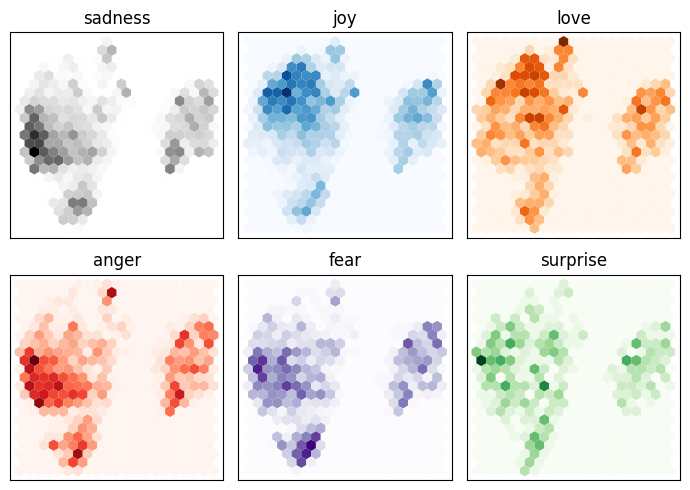

In [117]:
fig, axes = plt.subplots(2, 3, figsize=(7,5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = emotions["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
                   gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()

note: These are only projections onto a lower-dimensional space. Just because some categories overlap does not mean that they are not separable in the original space. Conversely, if they are separable in the projected space they will be separable in the original space.

From this plot we can see some clear patterns: the negative feelings such as sadness, anger, and fear all occupy similar regions with slightly varying distributions. On the other hand, joy and love are well separated from the negative emotions and also share a similar space. Finally, surprise is scattered all over the place. Although we may have hoped for some separation, this is in no way guaranteed since the model was not trained to know the difference between these emotions. It only learned them implicitly by guessing the masked words in texts.

Now that we've gained some insight into the features of our dataset, let's finally train a model on it!

**Training a simple classifier**

We've seen that the hidden states are somewhat different between the emotions, although for several of them there is no obvious boundary. Let's use these hidden states to train a logistic regression model with Scikit-Learn. Training such a simple model is fast and does not require a GPU:

In [118]:
#hide_output
# We increase `max_iter` to guarantee convergence 
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,3000
,multi_class,'deprecated'


In [119]:
lr_clf.score(X_valid, y_valid)

0.6345

Looking at the accuracy, it might appear that our model is just a bit better than random—but since we are dealing with an unbalanced multiclass dataset, it's actually significantly better. We can examine whether our model is any good by comparing it against a simple baseline. In Scikit-Learn there is a DummyClassifier that can be used to build a classifier with simple heuristics such as always choosing the majority class or always drawing a random class. In this case the best-performing heuristic is to always choose the most frequent class, which yields an accuracy of about 35%:

In [120]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.352

So, our simple classifier with DistilBERT embeddings is significantly better than our baseline. We can further investigate the performance of the model by looking at the confusion matrix of the classifier, which tells us the relationship between the true and predicted labels:

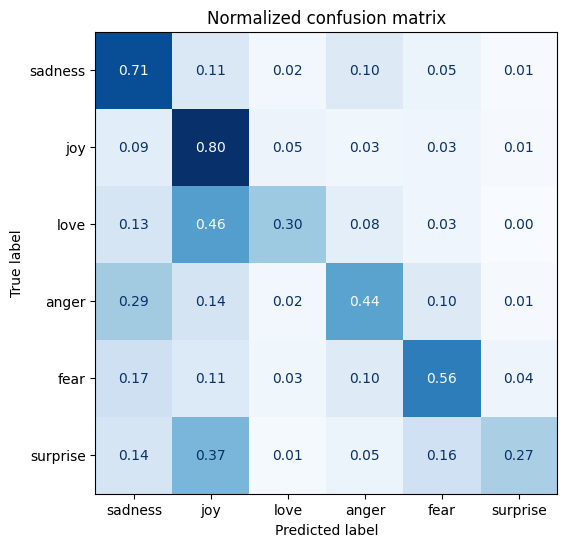

In [121]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()
    
y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

We can see that anger and fear are most often confused with sadness, which agrees with the observation we made when visualizing the embeddings. Also, love and surprise are frequently mistaken for joy.

In the next section we will explore the fine-tuning approach, which leads to superior classification performance. It is, however, important to note that doing this requires more computational resources, such as GPUs, that might not be available in your organization. In cases like these, a feature-based approach can be a good compromise between doing traditional machine learning and deep learning.

### Fine-Tuning Transformers

Let's now explore what it takes to fine-tune a transformer end-to-end. With the fine-tuning approach we do not use the hidden states as fixed features, but instead train them. This requires the classification head to be differentiable, which is why this method usually uses a neural network for classification.

Training the hidden states that serve as inputs to the classification model will help us avoid the problem of working with data that may not be well suited for the classification task. Instead, the initial hidden states adapt during training to decrease the model loss and thus increase its performance.

We'll be using the Trainer API from Transformers to simplify the training loop. Let's look at the ingredients we need to set one up!

**Loading a pretrained model**

The first thing we need is a pretrained DistilBERT model like the one we used in the feature-based approach. The only slight modification is that we use the AutoModelForSequenceClassification model instead of AutoModel. The difference is that the AutoModelForSequenceClassification model has a classification head on top of the pretrained model outputs, which can be easily trained with the base model. We just need to specify how many labels the model has to predict (six in our case), since this dictates the number of outputs the classification head has:

In [ ]:
# hide_output
from transformers import AutoModelForSequenceClassification

num_labels = 6
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels)
         .to(device))

You will see a warning that some parts of the model are randomly initialized. This is normal since the classification head has not yet been trained. The next step is to define the metrics that we'll use to evaluate our model's performance during fine-tuning.

**Defining the performance metrics**

To monitor metrics during training, we need to define a compute_metrics() function for the Trainer. This function receives an EvalPrediction object (which is a named tuple with predictions and label_ids attributes) and needs to return a dictionary that maps each metric's name to its value. For our application, we'll compute the $F_1$-score and the accuracy of the model as follows:

In [123]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

With the dataset and metrics ready, we just have two final things to take care of before we define the Trainer class:

1. Log in to our account on the Hugging Face Hub. This will allow us to push our fine-tuned model to our account on the Hub and share it with the community.
2. Define all the hyperparameters for the training run.
We'll tackle these steps in the next section.

**Training the model**

If you're running this code in a Jupyter notebook, you can log in to the Hub with the following helper function:

In [124]:
!pip install ipywidgets

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [125]:
from huggingface_hub import notebook_login
notebook_login()

### 🎯 Exercise 3: Feature Extraction and Model Selection

You've seen how to use transformers as feature extractors with a simple logistic regression classifier. Let's explore alternatives:

**Question 1:** Try using different classifiers from scikit-learn instead of logistic regression. Test at least two of the following: RandomForestClassifier, SVC (Support Vector Classifier), or MLPClassifier (Neural Network). Compare their performance with logistic regression. Which one works best and why?

In [127]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

svc = LinearSVC()
svc.fit(X_train, y_train)

svc_pred = svc.predict(X_valid)
svc_acc = accuracy_score(y_valid, svc_pred)

print("SVC validation accuracy:", svc_acc)



SVC validation accuracy: 0.629


In [128]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

rf_pred = rf.predict(X_valid)
rf_acc = accuracy_score(y_valid, rf_pred)

print("Random Forest validation accuracy:", rf_acc)


Random Forest validation accuracy: 0.524


In [129]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(256,), max_iter=20, random_state=42)
mlp.fit(X_train, y_train)

mlp_pred = mlp.predict(X_valid)
mlp_acc = accuracy_score(y_valid, mlp_pred)

print("MLP validation accuracy:", mlp_acc)


MLP validation accuracy: 0.622


/opt/anaconda3/envs/nlp_tp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Linear SVC is the classifier with the best performance, because transformer embeddings are already highly informative and nearly linearly separable. Linear models use this structure well, while tree-based models like Random Forests struggle in high-dimensional spaces.

**Question 2:** The UMAP visualization uses n_components=2 and metric="cosine". Read the UMAP documentation and experiment with different values for n_components (try 3), metric (try "euclidean"), and n_neighbors parameters. How does this affect the visualization and what insights can you gain?

/opt/anaconda3/envs/nlp_tp/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


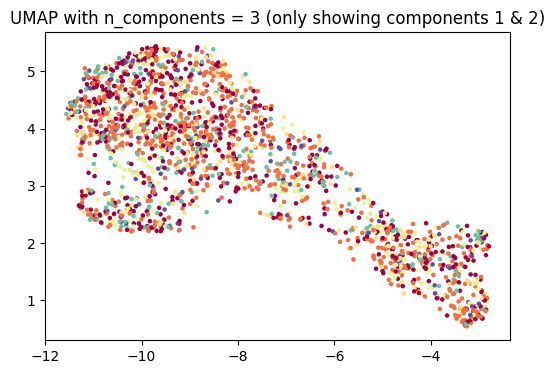

In [130]:
import umap.umap_ as umap
import matplotlib.pyplot as plt

reducer_3d = umap.UMAP(
    n_components=3,
    metric="cosine",
    n_neighbors=15,
    random_state=42
)

X_valid_3d = reducer_3d.fit_transform(X_valid)

plt.figure(figsize=(6, 4))
plt.scatter(X_valid_3d[:,0], X_valid_3d[:,1], c=y_valid, cmap="Spectral", s=5)
plt.title("UMAP with n_components = 3 (only showing components 1 & 2)")
plt.show()


/opt/anaconda3/envs/nlp_tp/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


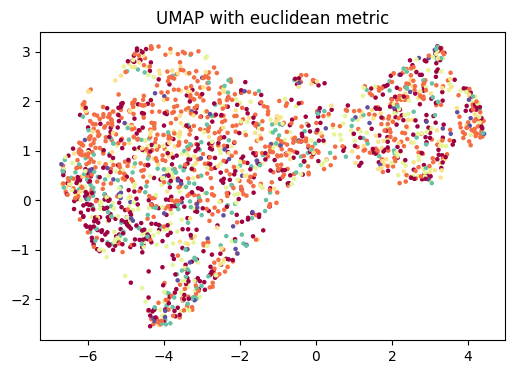

In [131]:
reducer_euclid = umap.UMAP(
    n_components=2,
    metric="euclidean",
    n_neighbors=15,
    random_state=42
)

X_valid_euclid = reducer_euclid.fit_transform(X_valid)

plt.figure(figsize=(6, 4))
plt.scatter(X_valid_euclid[:,0], X_valid_euclid[:,1], c=y_valid, cmap="Spectral", s=5)
plt.title("UMAP with euclidean metric")
plt.show()


/opt/anaconda3/envs/nlp_tp/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


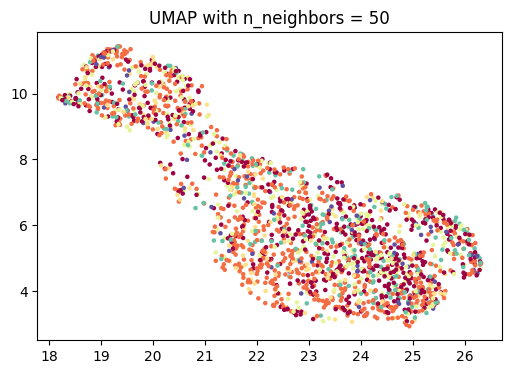

In [132]:
reducer_neighbors = umap.UMAP(
    n_components=2,
    metric="cosine",
    n_neighbors=50,
    random_state=42
)

X_valid_neighbors = reducer_neighbors.fit_transform(X_valid)

plt.figure(figsize=(6, 4))
plt.scatter(X_valid_neighbors[:,0], X_valid_neighbors[:,1], c=y_valid, cmap="Spectral", s=5)
plt.title("UMAP with n_neighbors = 50")
plt.show()


The visualizations do not produce clearly separated clusters, which is expected because emotion categories overlap 
Changing UMAP hyperparameters affects the shape of the embedding but does not create clear separation 

This will display a widget in which you can enter your username and password, or an access token with write privileges. You can find details on how to create access tokens in the Hub documentation. If you're working in the terminal, you can log in by running the following command:

$ huggingface-cli login

To define the training parameters, we use the TrainingArguments class. This class stores a lot of information and gives you fine-grained control over the training and evaluation. The most important argument to specify is output_dir, which is where all the artifacts from training are stored. Here is an example of TrainingArguments in all its glory: